In [40]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

#Matrix operations
from itertools import product

# Variable Elimination for the moralized graph

Implement inference algorithms for computing the conditional distribution of $X_{10}$ and $X_{11}$ given the observed variables for any choice of parameters $\psi^{(1)}, \ldots, \psi^{(11)}$.

### Synthetic data

In [41]:
alpha = 0.5

Elemination order

In [42]:
# The scope consist of the parents and the node itself
variables_to_eliminate = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9']
elimination_scope = [("X1", ['X7', 'X8']),("X2", ['X4', 'X8']),("X3", ['X9', 'X8']),
                     ("X5", ['X9', 'X8']),("X4", ['X11', 'X8', 'X9']),("X6", ['X7', 'X10']),
                     ("X7", []),("X8", []),("X9", ['X10', 'X6']), ("X10", ['X7']),("X11", ['X8', 'X9'])]


### From CPD to factor representation

In [43]:
def create_factor(variable,parent_list):
    d = 1 + len(parent_list)
    columns = parent_list + [variable]
    df = pd.DataFrame(product([0,1],repeat=d),columns=columns)
    return df

def cpd_factor(variable, parent_list, alpha):
    cpd = create_factor(variable, parent_list)
    variables = list(cpd.columns)
    n = len(variables)
    cpd_ = cpd.copy() 
    if n == 1:
        cpd_["prob"] = 1 - alpha
        return cpd_
    else:
        child = variables[n-1]
        # generate factor 
        parents = cpd_.iloc[:,:-1].copy()
        parents["sum"] = parents.sum(axis=1)
        cpd_["prob"] = 1 - (alpha ** (1 + parents["sum"]))
        # Update the probability where condition false
        # St. we can compute the probability of P(X=0|parents) = 1 - P(X=1|parents)
        cpd_["prob"].where(cpd_[f"{child}"] == 1, 1-cpd_["prob"],axis=0,inplace=True)
        return cpd_
    
factor_test = cpd_factor(elimination_scope[2][0], elimination_scope[2][1], alpha)
factor_test


C:\Users\huste\AppData\Local\Temp\ipykernel_14916\2494929028.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cpd_["prob"].where(cpd_[f"{child}"] == 1, 1-cpd_["prob"],axis=0,inplace=True)


,X9,X8,X3,prob
0,0,0,0,0.500
1,0,0,1,0.500
2,0,1,0,0.250
3,0,1,1,0.750
4,1,0,0,0.250
5,1,0,1,0.750
6,1,1,0,0.125
7,1,1,1,0.875


In [44]:
# Generate factors for all nodes
# list form: [(factor, protein name), ... ]
factor_list = []
for elm in elimination_scope:
    name = 'phi_' + str(elm[0])
    cpd = cpd_factor(elm[0], elm[1], alpha)
    factor_list.append((cpd, name))

print(factor_list[0])

(   X7  X8  X1   prob
0   0   0   0  0.500
1   0   0   1  0.500
2   0   1   0  0.250
3   0   1   1  0.750
4   1   0   0  0.250
5   1   0   1  0.750
6   1   1   0  0.125
7   1   1   1  0.875, 'phi_X1')


C:\Users\huste\AppData\Local\Temp\ipykernel_14916\2494929028.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cpd_["prob"].where(cpd_[f"{child}"] == 1, 1-cpd_["prob"],axis=0,inplace=True)
C:\Users\huste\AppData\Local\Temp\ipykernel_14916\2494929028.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alw

# Sum product

In [45]:
# Multiply factors togheter
def factor_product(factor_1, factor_2):
    # List of all common nodes to join on
    nodes_to_join = factor_1.columns.intersection(factor_2.columns)
    nodes_to_join = nodes_to_join.drop("prob")
    nodes = list(nodes_to_join)

    #Inner join the factors by common nodes
    new_factor = factor_1.merge(factor_2, how='inner', on=nodes)
    new_factor["prob"] = new_factor["prob_x"]*new_factor["prob_y"] # Mulætiply the probabilities
    new_factor = new_factor.drop(columns=["prob_x","prob_y"])
    return new_factor

factor_product(factor_list[0][0], factor_list[1][0])

,X7,X8,X1,X4,X2,prob
0,0,0,0,0,0,0.250000
1,0,0,0,0,1,0.250000
2,0,0,0,1,0,0.125000
3,0,0,0,1,1,0.375000
4,0,0,1,0,0,0.250000
5,0,0,1,0,1,0.250000
6,0,0,1,1,0,0.125000
7,0,0,1,1,1,0.375000
8,0,1,0,0,0,0.062500
9,0,1,0,0,1,0.187500


In [46]:
# From algorithm 9.1 in the book (p. 298)
def sum_product_eliminate_var(factors : list, var : int, print_info = False):
    factors_list = [i[0] for i in factors] # Factors
    names_list = [i[1] for i in factors] # Names of factors

    lst_scope = []   # Factors in scope
    lst_scope_i = [] # Names of factors in scope   
    lst_not_scope = [] # Factors not in scope
    lst_not_scope_i = [] # Names of factors not in scope

    # Split factors into scope and not scope
    for i in range(0, len(factors_list)):
        if var in factors_list[i].columns:
            lst_scope.append(factors_list[i])
            lst_scope_i.append(names_list[i])
        else:
            lst_not_scope.append(factors_list[i])
            lst_not_scope_i.append(names_list[i])

    # Multiply all factors in scope
    factor_ = lst_scope[0]
    for i in range(1, len(lst_scope)):
        factor_ = factor_product(factor_, lst_scope[i])

    # All variables that should not be marginalized
    col = list(factor_.columns[factor_.columns != var].drop("prob")) 

    # Marginalize the variable
    tau = factor_.groupby(col, as_index = False)['prob'].sum()
    tau_name = 'tau_' + str(var) 

    # Add the new factor to the list of factors not in scope
    lst_not_scope = lst_not_scope + [tau]
    lst_not_scope_i = lst_not_scope_i + [tau_name]
    
    # Debuggering prints
    if print_info:
        for elm in lst_scope:
            print(elm.columns)
        print(lst_scope_i)

    return list(zip(lst_not_scope, lst_not_scope_i))

print(sum_product_eliminate_var(factor_list, 'X1', False))

[(   X4  X8  X2   prob
0   0   0   0  0.500
1   0   0   1  0.500
2   0   1   0  0.250
3   0   1   1  0.750
4   1   0   0  0.250
5   1   0   1  0.750
6   1   1   0  0.125
7   1   1   1  0.875, 'phi_X2'), (   X9  X8  X3   prob
0   0   0   0  0.500
1   0   0   1  0.500
2   0   1   0  0.250
3   0   1   1  0.750
4   1   0   0  0.250
5   1   0   1  0.750
6   1   1   0  0.125
7   1   1   1  0.875, 'phi_X3'), (   X9  X8  X5   prob
0   0   0   0  0.500
1   0   0   1  0.500
2   0   1   0  0.250
3   0   1   1  0.750
4   1   0   0  0.250
5   1   0   1  0.750
6   1   1   0  0.125
7   1   1   1  0.875, 'phi_X5'), (    X11  X8  X9  X4    prob
0     0   0   0   0  0.5000
1     0   0   0   1  0.5000
2     0   0   1   0  0.2500
3     0   0   1   1  0.7500
4     0   1   0   0  0.2500
5     0   1   0   1  0.7500
6     0   1   1   0  0.1250
7     0   1   1   1  0.8750
8     1   0   0   0  0.2500
9     1   0   0   1  0.7500
10    1   0   1   0  0.1250
11    1   0   1   1  0.8750
12    1   1   0   0  0.1250


In [47]:
def sum_product_ve(factors, order):

    # For each variable in the elimination order
    for var in order:
        factors = sum_product_eliminate_var(factors, var)
    return factors

print(sum_product_ve(factor_list, variables_to_eliminate))

[(   X11  X10      prob
0    0    0  0.095215
1    0    1  0.134399
2    1    0  0.279785
3    1    1  0.490601, 'tau_X9')]


In [48]:
# If a variable is in query it cannot be in variables_to_eliminate
# variables_to_eliminate = K - query_var
# evidence contains the same variables as variables_to_eliminate
K = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11']
variables_to_eliminate = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9']
evidence = [('X1', 1), ('X2',1), ('X3',1),('X4',1),("X5",1),('X6',1),('X7',1),('X8',1),('X9',1)]
#evidence = [('X11',1)]
query_var = ['X10', 'X11']

# k - parameterizing nework k over X
# query_var - Set of query variables Y
# order - Elimination order (order)
# evidence - observed values e for variables in E
def cond_prob_ve (factors: list, queries: list, evidence: list, order: list):
    order_ = order.copy() # Fix for wierd python handeling of list
    factors_list = [i[0] for i in factors] # Factors
    names_list = [i[1] for i in factors] # Names of factors

    for i in range(0,len(factors_list)): # Loop through factors
        for elm in evidence: # Loop through evidence
            if elm[0] in factors_list[i].columns:
                # Retrict factor to evidence == e, and replace in factor list
                factors_list[i] = factors_list[i][factors_list[i][elm[0]]==elm[1]]
    
    # Remove elemetns we want to keep from elemination order
    # for elm in evidence:
    #     order_.remove(elm)
    
    concat_factor_list = list(zip(factors_list,names_list))
    #print(len(factors_list), len(names_list), '\n', names_list)
    
    phi = sum_product_ve(concat_factor_list, order_)
    #print(phi)

    alpha = phi[0][0].groupby(queries, as_index = False)['prob'].sum()
    alpha['prob'] = alpha['prob'] / alpha['prob'].sum() # Normalize the probability
   
    return alpha, phi

cond_prob_ve(factor_list, query_var, evidence, variables_to_eliminate)

(   X10  X11      prob
 0    0    0  0.023144
 1    0    1  0.173578
 2    1    0  0.094503
 3    1    1  0.708775,
 [(   X11  X10      prob
   0    0    0  0.002254
   1    0    1  0.009204
   2    1    0  0.016905
   3    1    1  0.069029,
   'tau_X9')])

# Apply sum-product

The following code "proofs" that our algorithm works.
 - It do take a long time to run, but the we should be able to optimize if we don't run cond_prob_ve inside the for-loop in the function dataframe_inference

Apply evidence to the inference algorithm:
 - Loop through each row in the dataframe and apply the columns to sum_product as evidence.

### Load data

In [49]:
# Initialize the dataset
column_names = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'remove1', 'remove2']
pd_dataset = pd.read_csv("dataset/forward_simulation.csv") 
pd_dataset = pd_dataset.rename(columns=dict(zip(pd_dataset.columns, column_names)))
pd_dataset = pd_dataset.drop(columns=['remove1', 'remove2'], axis=0)


pd_dataset.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9
0,1,1,1,1,1,1,0,1,0
1,1,0,1,0,1,1,0,0,1
2,1,1,0,1,0,0,1,0,1
3,1,1,1,1,1,1,0,1,1
4,1,1,1,1,1,1,1,1,1


### inference

In [50]:
##### Helper function to create a factor from a dataset

# Convert into the same format as the evidence list by 
# looping through the data and create a list of tuples
#   data - List of lists with data
#   pick - List of variables X1, ..., X9
def convert_to_evidence_format(data : list, pick : list) -> list:
    # Loop through the data and create a list of tuples
    evidence = []

    # Loop through columns
    for i in range(0, len(data)):
        lst = []
        # Loop through rows
        for j in range(0, len(data[i])):
            # Append the tuple (X1, 1) or (X2, 0) etc.
            lst = lst + [(pick[j], data[i][j])]
        evidence = evidence + [lst]

    return evidence

# Given a dataframe convert into the same format as the evidence list
# pick - List of variables X1, ..., X9
def dataframe_to_evidence(df : pd.DataFrame, pick : list) -> list:
    data = [] 
    
    # Convert dataframe to list(col) of list(row)
    for index, row in pd_dataset.iterrows():
        row_list = row.tolist()  
        data.append(row_list)  

    #Convert into the same format as the evidence list
    evidence = convert_to_evidence_format(data, pick)
    
    return evidence

In [51]:
# We keep a copy of the original dataset
K = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11']
variables_to_eliminate = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9']
query_var = ['X10', 'X11']

# df - Dataframe containing all columns
# pick - List of variables X1, ..., X9 that we want to use as evidence
# query_var - List of variables we want to query
# order - Elimination order
def dataframe_inference(df : pd.DataFrame, pick : list, query_var : list, order : list) -> list:
    evidence = dataframe_to_evidence(df, pick)
    lst_prob = []

    ##### ----- We concatenate the probabilities to the original dataset ----- #####
    # Loop through evidence and calculate the probability of the query variable
    for elm in evidence:
        # If there is multiple query variables we get a joint distribution,

        values = [] # List of probabilities for each query variable
        for i in range(0, len(query_var)):
            prob = cond_prob_ve(factor_list, query_var, elm, variables_to_eliminate)[0] # Apply sum_product_ve
            prob_marginal = prob.groupby(query_var[i], as_index = False)['prob'].sum() # Marginalize the probability, to get a probability for each query variable
            prob_value = prob_marginal[prob_marginal[query_var[i]]==1].iloc[0]['prob'] # Get the probability of the query variable

            values = values + [prob_value]
        lst_prob = lst_prob + [values]


    # Convert list of probabilities to dataframe concatenated with the original dataset
    query_var_prob_names = [x + '_prob' for x in query_var]
    df_prob = pd.DataFrame(lst_prob, columns=query_var_prob_names)
    df_prob = pd.concat([df, df_prob], axis=1)
    

    ##### ----- Simulate the data based on the probability ----- #####
    for elm in query_var:
        df_prob[elm] = np.random.binomial(1, df_prob[elm + '_prob'])

        
    return df_prob
inference_date = dataframe_inference(pd_dataset, column_names, query_var, variables_to_eliminate)
print(inference_date)

     X1  X2  X3  X4  X5  X6  X7  X8  X9  X10_prob  X11_prob  X10  X11
0     1   1   1   1   1   1   0   1   0  0.428571  0.777778    1    1
1     1   0   1   0   1   1   0   0   1  0.636364  0.600000    0    1
2     1   1   0   1   0   0   1   0   1  0.692308  0.777778    1    1
3     1   1   1   1   1   1   0   1   1  0.636364  0.882353    0    1
4     1   1   1   1   1   1   1   1   1  0.803279  0.882353    1    1
..   ..  ..  ..  ..  ..  ..  ..  ..  ..       ...       ...  ...  ...
995   1   1   0   0   0   1   0   1   0  0.428571  0.600000    0    0
996   1   1   0   0   1   1   1   1   0  0.636364  0.600000    1    0
997   0   1   1   0   1   1   0   0   1  0.636364  0.600000    1    1
998   1   1   1   1   1   0   1   0   1  0.692308  0.777778    0    1
999   1   1   0   1   0   1   0   1   1  0.636364  0.882353    0    0

[1000 rows x 13 columns]


### plot data

Seems like the algorith works, based of comparrison with the plot in part_1

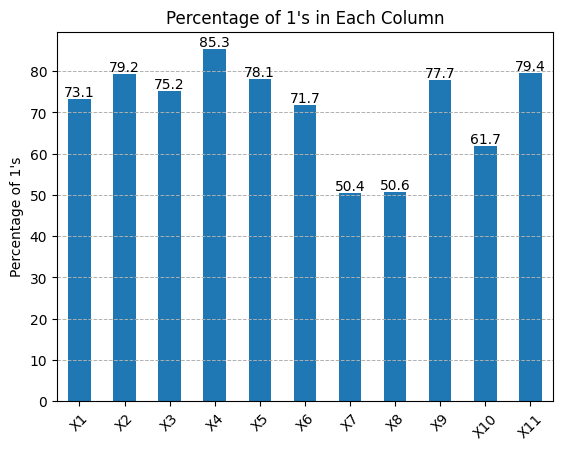

In [52]:
inference_date = inference_date.drop(columns=['X10_prob', 'X11_prob'], axis=0)

percentages = inference_date.mean() * 100  # mean() calculates the proportion of 1s, multiplying by 100 gives the percentage

# Plotting
fig, ax = plt.subplots()
percentages.plot(kind='bar', ax=ax)
ax.bar_label(ax.containers[0])
ax.set_ylabel('Percentage of 1\'s')
ax.set_title('Percentage of 1\'s in Each Column')
plt.xticks(rotation=45)  # Rotate labels to make them readable
plt.grid(axis='y', linestyle='--', linewidth=0.7)  # Add gridlines for better readability
plt.show()